# 摘要

期货期限结构的定义和经济解释, 展期收益率的定义和建模, 利用期限结构的期货交易策略

# 理论模型

## 期限结构

商品期货的期限结构是指商品期货价格与不同的到期期限的关系。一般来说商品期限结构特点分为两种：
* **远月贴水(Backwardation)**: 远月合约价格低于近月合约.
* **近月贴水(Contango)**: 近月合约价格低于远月.

**期限价差（Calendar Spread）**是指由相同标的不同到期日的期货组成的多空投资组合。


### 交割延期理论

最早由 Keynes 和 Hicks 在 20 世纪 30 年代提出的, 即生产和消费(包括使用商品作为投入品的制造商的需求活动)的基础条件是, 生产者必须比消费者向前看得远的多, 套期保值者作为一个整体倾向于空头, 为了劝说投机者持有多头的态度, 必须给予一个正数的风险补偿, 即"卖方付给买方的正常交割延期费用", 由于近月合约更贴近于现货价格, 所以远月套保价格应该较低. 因而在正常情况下, 远期价格应该低于近期价格(远月贴水). 

此理论潜在假设是投机者是有理性的, 即他们根据各种有用的信息对预期期货价格进行分析. 虽然理性的投机者偶尔会犯错误, 但作为整体, 他们对信息的分析是有效的. 因此, 在合约到期前, 每一期货价格都会趋向于提高到与相应的现货价格相等为止. 此理论提出后, 不断有学者对其验证, 发现了市场上存在一些矛盾, 从长期的结论来看, 交割延期费理论对某些特定的市场在特定条件下是有效的, 但是作为对一般商品行为的解释是不充分的.


### 套期保值压力理论

期货市场的参与者可以分为套期保值者和投机者，前者的目的在于锁定自身收益，对冲未来标的价格变动的风险，愿意支付风险补偿来转移风险；投机者是风险偏好者，愿意承担风险但需要风险补偿。

套期保值压力理论认为，正是这种风险的转移导致了现货市场与期货市场的基差。具体解释如下：如果套保者是一个生产商，他希望对冲掉未来产品价格下降而带来的风险，卖出期货合约，此时持有空头的净头寸。为了将风险转移宁愿支付风险补偿，所以期货合约价格将低于基于现货价格的未来期望价格。随着期货合约的到期，期货价格不断上升，趋于现货的期望价格，持有多头净头寸的投机者获得风险补偿；如果套保者是希望锁定原材料成本的加工商，持有净的多头头寸。为了对冲掉原材料价格上涨的风险， 愿意支付高于现货未来期望的价格来购买合约。因此，期货价格在到期的过程中下降，持有空头头寸的投机者获得风险补偿。

### 仓储价格理论(Price of Storage Theory) 

又称仓储供应理论(Supply of Storage Theory)或仓储成本理论(Cost-of-Carry theory). 卡尔多(1939)首次提出了便利收益(convenience yield)在仓储决定中的重要性. 后来 Brennan 等人沿着这个方向对仓储价格理论进行了完善. 仓储价格理论论证了期货价格, 现货价格, 仓储费和仓储量之间的密切关系. 其主要观点是仓储的边际报酬即基差等于边际净仓储成本加上风险报酬, 减去便利收益. 

仓储价格理论提出的一个重要概念是便利收益, 所谓便利收益就是持有存货所带来的除了价格上涨的期望收益. 制造商和中间商获得便利收益与社会的库存水平成反比, 社会的库存水平越高, 他们所获得的便利收益就越小, 现货的便利收益的降低将会影响现货以及近月合约的价格, 从而使得近月更容易出现贴水状态, 反之当社会库存水平较低时, 便利收益越大, 远月更容易出现贴水的情况. 仓储价格理论相对于交割延期理论更好的解释了期限结构, 说明了期货价格对现货供求调节的原因, 期货价格能够调节现货供求, 这种调节功能是通过仓储过程实现的.

根据仓储理论，反观市场的期限结构，便可反推出市场的供需情况，进而设计投资策略盈利.

当库存偏低时, 近月价格将出现更多的上行, 从而更容易导致远月合约贴水, 此后由于库存偏低, 则商品价格将可能继续上涨, 从而此时应该买入该商品品种; 反之当库存偏高时, 近月合约价格将下行更多, 更容易导致近月合约贴水, 此后由于库存偏高, 商品价格可能继续下行, 此时该卖出该商品品种.

## 展期收益率(Roll Return，Roll Yield)

不同到期日的期货价格不同意味着即便现货价格一直保持不变，期货头寸也会有非零收益率（到期时期货价格强制收敛到现货价格）。这个收益率即为展期收益率，或者看做投资者平仓近月合约，买入远月合约的年化收益率。在连续情形下，展期收益率定义为期货价格关于到期时间的导数的相反数：
$$
\gamma_t = -\frac{\partial(\log F(t,T))}{\partial T}
$$
其中，$t$为当前时点，$T$为到期时刻。离散情形下有：
\begin{equation}\label{eq:roll-yield}
\gamma_t = \frac{\log F(t,T_N)-\log F(t,T_F)}{T_F-T_N}
\end{equation}
其中, $F(t,T_N)$ 是近月合约(或者现货)在 t 时刻的价格, $T_N$ 是近月合约(现货为 t)的到期时间, $F(t,T_F)$ 是远月合约在 t 时刻的价格, $T_F$ 是远月合约的到期时间. 如果时间的度量以年为单位, 则计算的是年化的展期收益率。当处于远月贴水状态下，近月合约比远月合约价格高，展期收益率为正；当处于近月贴水状态下，近月合约比远月合约价格低，展期收益率为负。

<img src=".\images\展期收益率.PNG" width=500 height=227>

期货的总收益率可以分解成现货收益率（Spot Return）和展期收益率两部分（\cite{Chan:2013}），假设期货价格为：
$$
F(t,T) = S(t)e^{\gamma(t-T)}
$$
其中，$S(t)$是现货价格，$\gamma$是展期收益率，这里假设其为常数。假设现货价格服从：
$$
S(t)=S_0e^{\alpha t}
$$
其中，$\alpha$为现货收益率，假设也为常数。从而有：
$$
F(t,T) = S_0e^{\alpha t+\gamma(t-T)}
$$
则期货的总收益率为：
$$
\frac{\partial(\log F(t,T))}{\partial t} = \alpha+\gamma
$$
而期货的展期收益率为：
$$
-\frac{\partial(\log F(t,T))}{\partial T} = \gamma
$$
从而，从总收益率=现货收益率+展期收益率。

展期收益率去除了期限价差的时间因素，方便各个品种的比较，且当展期收益率为正时表明此时远月贴水，反之近月贴水，且其绝对值越大，贴水程度越高。

可以用期货和现货的对数价格关于到期时间的线性回归系数估计展期收益率，然而鉴于流动性的问题，也可以仅使用主力合约和次主力合约来估计展期收益率。

展期收益率的符号不会频繁的变化，这使得期货合约会长时间的保持在远月贴水或者近月贴水的状态。相比之下，现货收益率的波动性较大，如果平均来看展期收益率在总收益率中占据主导，则会导致期货收益率呈现一定的序列相关性。（\cite{Chan:2013}）

# 实证分析

In [1]:
# coding=utf-8
import sys
sys.path.append("D:\\HST\\QuantStudio")
sys.path.append("C:\\Users\\hushuntai\\svn\\python")
import datetime as dt

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook

import QuantStudio.api as QS
WDB = QS.FactorDB.WindDB2()

## 展期收益率

In [2]:
# 参数设置以及数据准备
SpotID = "000300.SH"# 现货 ID
MID, SID = "IF.CFE", "IF_S.CFE"# 目标期货主力和次主力合约 ID
CCIDs = ["IF00.CFE", "IF01.CFE", "IF02.CFE", "IF03.CFE"]# 连续合约 ID

# SpotID = None# 无现货 ID
# MID, SID = "AU.SHF", "AU_S.SHF"# 目标期货主力和次主力合约 ID
# CCIDs = ["AU00.SHF", "AU01.SHF", "AU02.SHF", "AU03.SHF", "AU04.SHF"]# 连续合约 ID

StartDT = dt.datetime(2012, 6, 1)# 回测开始日期
EndDT = dt.datetime(2017, 12, 31)# 回测截止日期

WDB.connect()
DTs = WDB.getTable("中国期货交易日历").getDateTime(iid="SHFE", start_dt=StartDT, end_dt=EndDT)
# 获取现货价格
FT = WDB.getTable("中国A股指数日行情")
SpotPrice = FT.readData(factor_names=["收盘价(点)"], ids=[SpotID], dts=DTs).iloc[0, :, 0]
# 获取连续合约的月合约 ID
FT = WDB.getTable("中国期货连续(主力)合约和月合约映射表")
FutureIDMap = FT.readData(factor_names=["映射月合约Wind代码"], ids=[MID,SID]+CCIDs, dts=DTs).iloc[0,:,:]
# 获取主力和次主力合约的月合约到期日
MonthIDs = FutureIDMap.values.flatten()
MonthIDs = sorted(np.unique(MonthIDs[pd.notnull(MonthIDs)]))
FT = WDB.getTable("中国期货基本资料")
LastTradeDate = FT.readData(factor_names=["最后交易日期"], ids=MonthIDs, dts=[EndDT]).iloc[0, 0]
LastTradeDate = pd.DataFrame([FutureIDMap[iID].apply(lambda x: LastTradeDate[x] if pd.notnull(x) else None) for iID in [MID,SID]+CCIDs],index=[MID,SID]+CCIDs).T
ExpirationDays = pd.DataFrame(np.nan, index=LastTradeDate.index, columns=LastTradeDate.columns)
for i, iDT in enumerate(DTs):
    ExpirationDays.iloc[i] = LastTradeDate.iloc[i].apply(lambda x: (dt.datetime.strptime(x, "%Y%m%d") - iDT).days)
# 获取期货合约的价格
FT = WDB.getTable("中国股指期货日行情")
# FT = WDB.getTable("中国商品期货日行情")
MSPrice = FT.readData(factor_names=["结算价(元)"], ids=[MID, SID], dts=DTs).iloc[0]
CCPrice = FT.readData(factor_names=["结算价(元)"], ids=CCIDs, dts=DTs).iloc[0]
MonthPrice = FT.readData(factor_names=["结算价(元)"], ids=MonthIDs, dts=DTs).iloc[0]
WDB.disconnect();

可以使用主力合约和次主力合约利用公式 (\ref{eq:roll-yield}) 估计展期收益率：

Average Annualized Roll Return: 4.12%

Roll Yield ADF Test
Statistic : -2.461527
pvalue : 0.125118
usedlag : 5


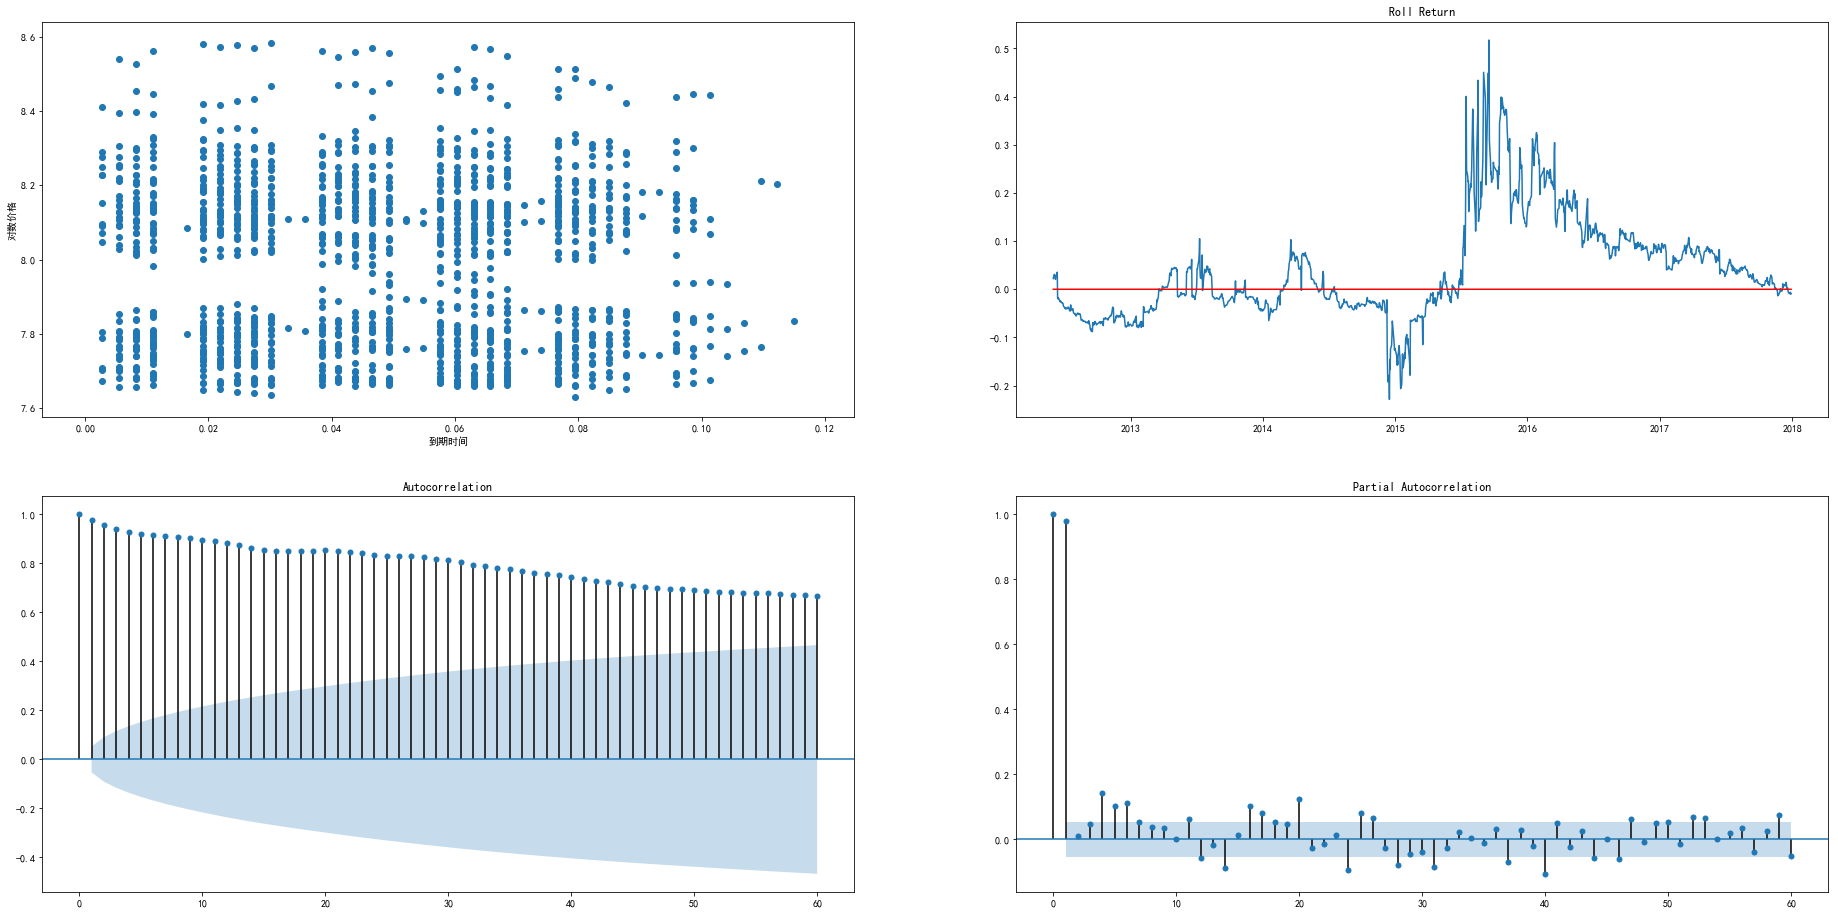

In [3]:
# 使用主力合约和次主力合约估计展期收益率
Fun = lambda x: (dt.datetime.strptime(x.iloc[0], "%Y%m%d") - dt.datetime.strptime(x.iloc[1], "%Y%m%d")).days / 365 if (pd.notnull(x.iloc[0]) and pd.notnull(x.iloc[1])) else np.nan
TimeDelta = LastTradeDate.loc[:, [MID, SID]].apply(Fun, axis=1)
RollYield_MS = np.diff(np.log(MSPrice), axis=1)[:, 0] / TimeDelta
print("Average Annualized Roll Return: %.2f%%" % (RollYield_MS.mean()*100, ), end="\n\n")

# 平稳性检验
# ADF 检验
ADFTest = sm.tsa.stattools.adfuller(RollYield_MS[pd.notnull(RollYield_MS)].values, regression='c', autolag="BIC")
print("Roll Yield ADF Test",
      ("Statistic : %f" % ADFTest[0]), 
      ("pvalue : %f" % ADFTest[1]), 
      ("usedlag : %d" % ADFTest[2]), sep="\n")

Fig, Axes = plt.subplots(2, 2, figsize=(32, 16))
Axes[0, 0].scatter(ExpirationDays.iloc[:, 0].values / 365, np.log(MSPrice.iloc[:, 0].values))
Axes[0, 0].set_xlabel("到期时间")
Axes[0, 0].set_ylabel("对数价格");
Axes[0, 1].plot(RollYield_MS)
Axes[0, 1].plot(RollYield_MS.index, np.zeros(RollYield_MS.shape[0]), color="r")
Axes[0, 1].set_title("Roll Return")
sm.graphics.tsa.plot_acf(RollYield_MS[pd.notnull(RollYield_MS)].values, lags=60, ax=Axes[1, 0])
sm.graphics.tsa.plot_pacf(RollYield_MS[pd.notnull(RollYield_MS)].values, lags=60, ax=Axes[1, 1]);

也可以通过回归来估计展期收益率：


Average Annualized Roll Return: 0.01%
Roll Yield ADF Test Statistic : -1.817907
pvalue : 0.371608
usedlag : 5


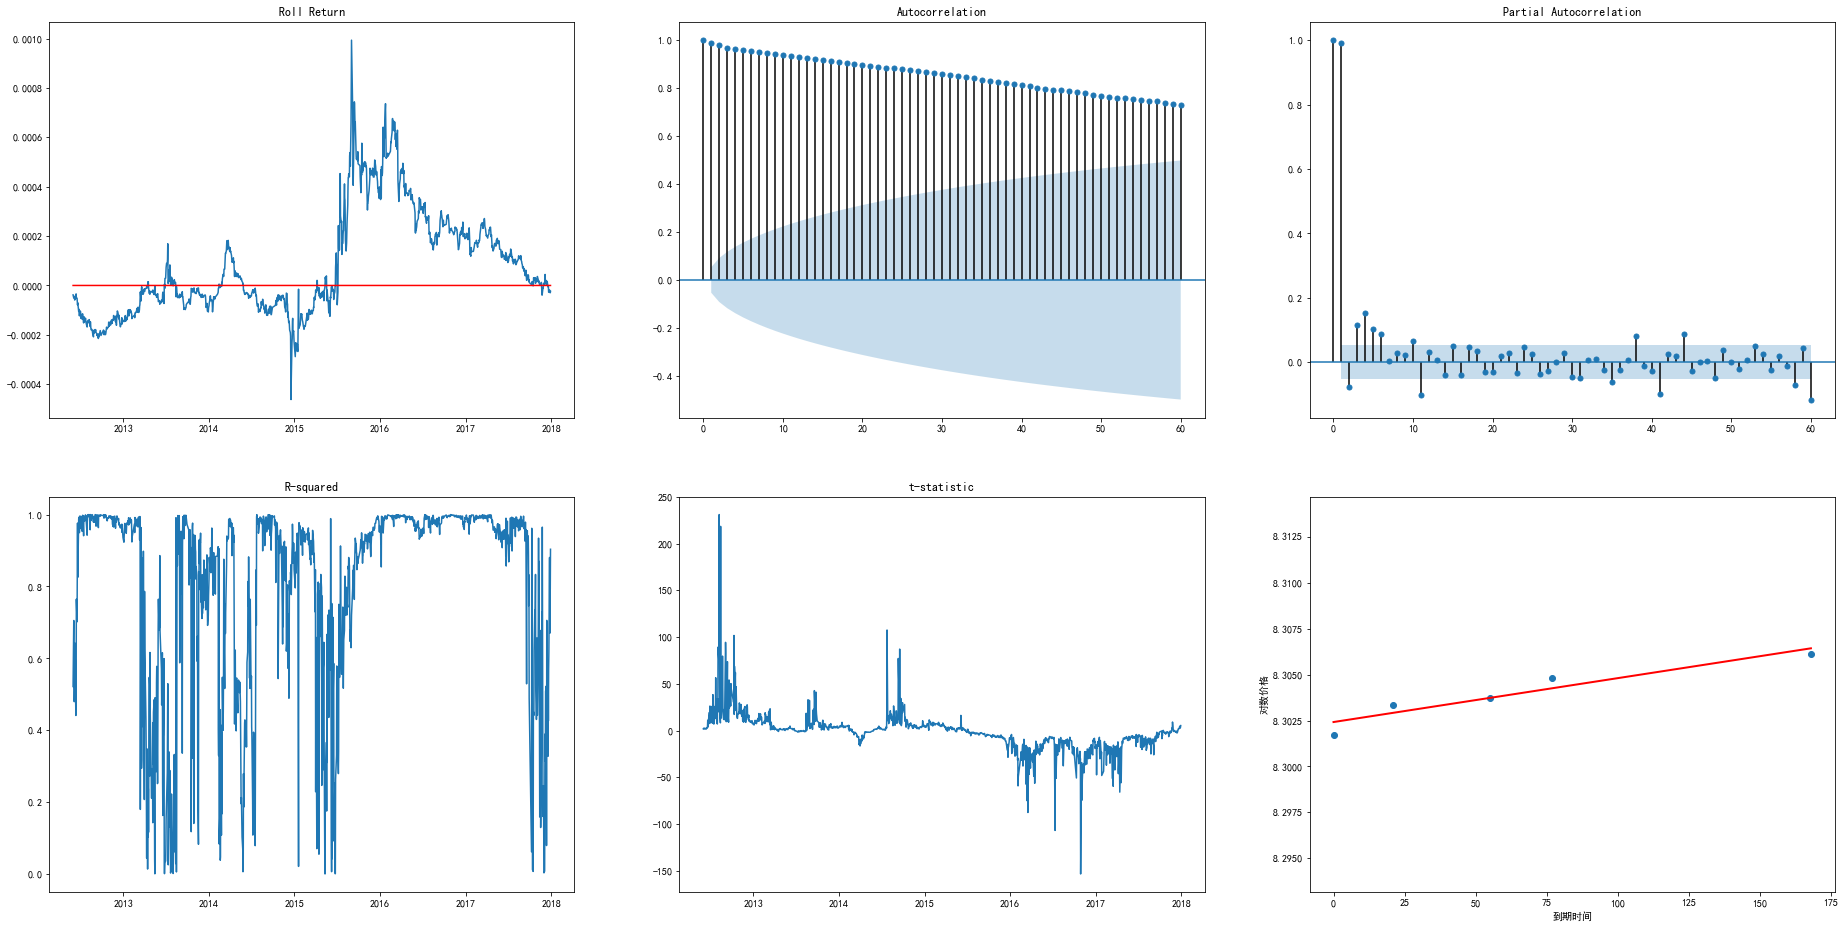

In [4]:
# 使用所有合约回归来估计展期收益率
RollYield_OLS = np.full(CCPrice.shape[0], np.nan)
RegStats = pd.DataFrame(np.nan, index=CCPrice.index, columns=["R-squared", "Adj. R-squared", "F-statistic", "t-statistic"])
for i, iDT in enumerate(tqdm_notebook(CCPrice.index, desc="日期 loop")):
    iX = ExpirationDays.iloc[i, 2:].values
    iY = np.log(CCPrice.iloc[i].values)
    if SpotID is not None:
        iX = np.r_[0, iX]
        iY = np.r_[np.log(SpotPrice.iloc[i]), iY]
    iRegRslt = sm.OLS(iY, sm.add_constant(iX, prepend=False), missing="drop").fit()
    RollYield_OLS[i] = - iRegRslt.params[0]
    RegStats.iloc[i] = (iRegRslt.rsquared, iRegRslt.rsquared_adj, iRegRslt.fvalue, iRegRslt.tvalues[0])
RollYield_OLS = pd.Series(RollYield_OLS, index=CCPrice.index)
print("Average Annualized Roll Return: %.2f%%" % (RollYield_OLS.mean()*100, ))

# 平稳性检验
# ADF 检验
ADFTest = sm.tsa.stattools.adfuller(RollYield_OLS[pd.notnull(RollYield_OLS)].values, regression='c', autolag="BIC")
print(("Roll Yield ADF Test Statistic : %f" % ADFTest[0]), 
      ("pvalue : %f" % ADFTest[1]), 
      ("usedlag : %d" % ADFTest[2]), sep="\n")

Fig, Axes = plt.subplots(2, 3, figsize=(32, 16))
Axes[0, 0].plot(RollYield_OLS)
Axes[0, 0].plot(RollYield_OLS.index, np.zeros(RollYield_OLS.shape[0]), color="r")
Axes[0, 0].set_title("Roll Return")
sm.graphics.tsa.plot_acf(RollYield_OLS[pd.notnull(RollYield_OLS)].values, lags=60, ax=Axes[0, 1])
sm.graphics.tsa.plot_pacf(RollYield_OLS[pd.notnull(RollYield_OLS)].values, lags=60, ax=Axes[0, 2])
Axes[1, 0].plot(RegStats["R-squared"])
Axes[1, 0].set_title("R-squared")
Axes[1, 1].plot(RegStats["t-statistic"])
Axes[1, 1].set_title("t-statistic")
Axes[1, 2].scatter(iX, iY)
Axes[1, 2].plot(iX, iRegRslt.params[0]*iX+iRegRslt.params[1], color="r", linewidth=2)
Axes[1, 2].set_xlabel("到期时间")
Axes[1, 2].set_ylabel("对数价格");

从平稳性检验和自相关函数的图像来看, 展期收益率本身并不平稳。

下面利用回归的方式估计现货收益率。

Average Annualized Spot Return: 10.74%


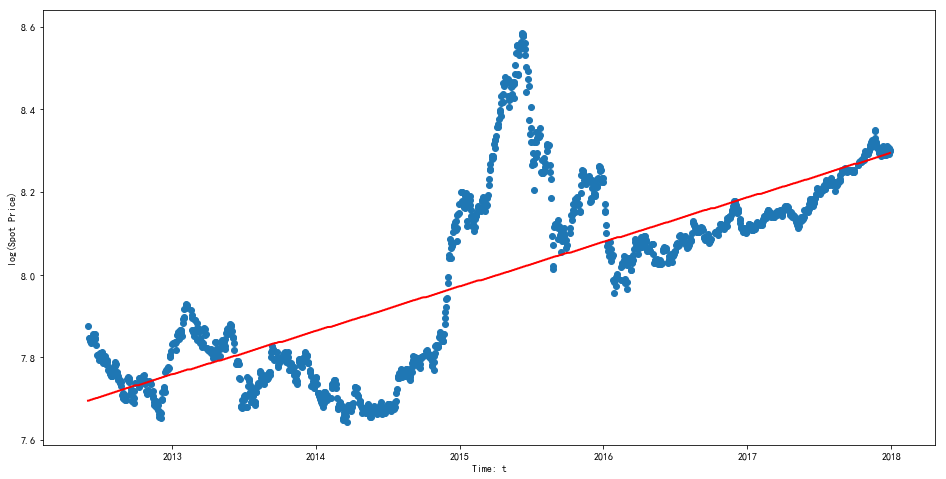

In [7]:
# 估计 Spot Return
if SpotID is not None:
    RegRslt = sm.OLS(np.log(SpotPrice.values), sm.add_constant(np.arange(SpotPrice.shape[0]), prepend=False), missing="drop").fit()
    SpotReturn = RegRslt.params[0] * SpotPrice.shape[0] / (SpotPrice.index[-1] - SpotPrice.index[0]).days * 365
    print("Average Annualized Spot Return: %.2f%%" % (SpotReturn * 100, ))

    Fig, Axes = plt.subplots(figsize=(16, 8))
    Axes.set_xlabel("Time: t")
    Axes.set_ylabel("log(Spot Price)")
    Axes.scatter(SpotPrice.index, np.log(SpotPrice.values))
    Axes.plot(SpotPrice.index, RegRslt.params[0] * np.arange(SpotPrice.shape[0]) + RegRslt.params[1], color="r", linewidth=2);

In [ ]:
# --------平稳性检验--------
# ADF 检验
RollYieldADFTest = sm.tsa.stattools.adfuller(RollYield.values, regression='c', autolag="BIC")
print(("Roll Yield ADF Test Statistic : %f" % RollYieldADFTest[0]), 
      ("pvalue : %f" % RollYieldADFTest[1]), 
      ("usedlag : %d" % RollYieldADFTest[2]), sep="\n")

# Hurst 指数
from QuantStudio.Tools.MathFun import genHurstExp
RollYieldHurstExp, _ = genHurstExp(RollYield.values)
print("Roll Yield Hurst Exponent : %f" % RollYieldHurstExp)

# ACF, PACF
DiffRollYield = RollYield.diff().iloc[1:]
Fig, Axes = plt.subplots(2, 3, figsize=(32, 16))
Axes[0, 0].plot(RollYield)
Axes[0, 0].set_title("Roll Yield")
sm.graphics.tsa.plot_acf(RollYield, lags=60, ax=Axes[0, 1])
sm.graphics.tsa.plot_pacf(RollYield, lags=60, ax=Axes[0, 2])
Axes[1, 0].plot(DiffRollYield)
Axes[1, 0].set_title("Diff. of Roll Yield")
sm.graphics.tsa.plot_acf(DiffRollYield, lags=60, ax=Axes[1, 1])
sm.graphics.tsa.plot_pacf(DiffRollYield, lags=60, ax=Axes[1, 2]);

## 期限价差

---------- Calendar Cointegration Johansen Test: r<=0 ----------
Trace Statistic : 10.576155
Critical Values (90%, 95%, 99%) : [13.4294 15.4943 19.9349]
Maximum Eigenvalue Statistic Statistic : 10.572060
Critical Values (90%, 95%, 99%) : [12.2971 14.2639 18.52  ]

---------- Calendar Cointegration Johansen Test: r<=1 ----------
Trace Statistic : 0.004095
Critical Values (90%, 95%, 99%) : [2.7055 3.8415 6.6349]
Maximum Eigenvalue Statistic Statistic : 0.004095
Critical Values (90%, 95%, 99%) : [2.7055 3.8415 6.6349]



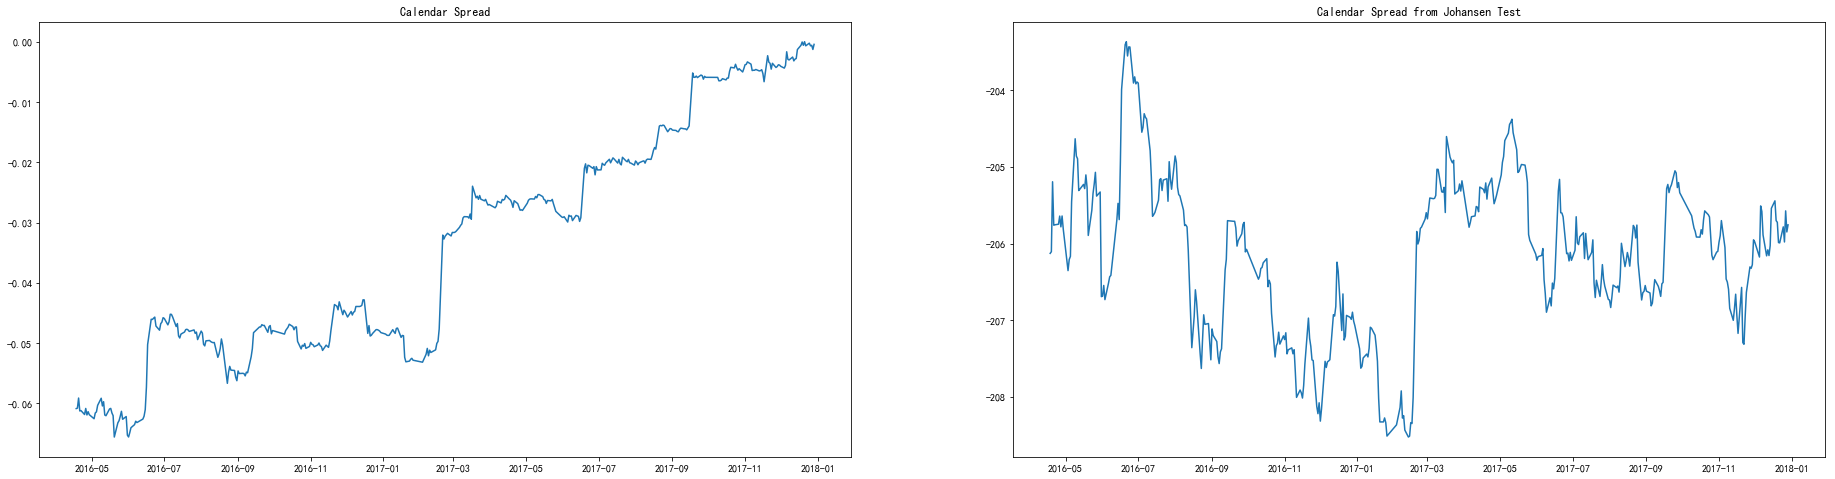

In [40]:
# 计算两个合约的期限价差
# 对连续合约的价格进行前复权调整
AdjCCPrice = pd.DataFrame({iID:QS.Tools.Strategy.genContinuousContractPrice(FutureIDMap[iID], MonthPrice, adj_direction="前复权", 
                                                                            adj_type="收益率不变", rollover_ahead=True) for iID in CCIDs}).loc[:, CCIDs]
# AdjCCPrice = CCPrice
CalendarSpread = np.log(AdjCCPrice.iloc[:, 0]) - np.log(AdjCCPrice.iloc[:, 1])# 当月合约 - 下月合约

# 协整检验
X = np.log(AdjCCPrice.iloc[:, 0:2])
CalendarJohansenTest = sm.tsa.var.vecm.coint_johansen(X, det_order=0, k_ar_diff=1)
for i in range(CalendarJohansenTest.lr1.shape[0]):
    print(("---------- Calendar Cointegration Johansen Test: r<=%d ----------" % (i, )),
          ("Trace Statistic : %f" % (CalendarJohansenTest.lr1[i], )), 
          ("Critical Values (90%%, 95%%, 99%%) : %s" % (str(CalendarJohansenTest.cvt[i]), )), 
          ("Maximum Eigenvalue Statistic Statistic : %f" % (CalendarJohansenTest.lr2[i], )), 
          ("Critical Values (90%%, 95%%, 99%%) : %s" % (str(CalendarJohansenTest.cvm[i]), )), sep="\n", end="\n\n")

Fig, Axes = plt.subplots(1, 2, figsize=(32, 8))
Axes[0].plot(CalendarSpread)
Axes[0].set_title("Calendar Spread")
Axes[1].plot(CalendarSpread.index, np.dot(X, CalendarJohansenTest.evec[:, 0]))
Axes[1].set_title("Calendar Spread from Johansen Test");

3 Contract Calendar Spread ADF Test
Statistic : -1.095016
pvalue : 0.717055
usedlag : 0

---------- 3 Contract Calendar Cointegration Johansen Test: r<=0 ----------
Trace Statistic : 22.866529
Critical Values (90%, 95%, 99%) : [27.0669 29.7961 35.4628]
Maximum Eigenvalue Statistic Statistic : 15.704307
Critical Values (90%, 95%, 99%) : [18.8928 21.1314 25.865 ]

---------- 3 Contract Calendar Cointegration Johansen Test: r<=1 ----------
Trace Statistic : 7.162222
Critical Values (90%, 95%, 99%) : [13.4294 15.4943 19.9349]
Maximum Eigenvalue Statistic Statistic : 7.161762
Critical Values (90%, 95%, 99%) : [12.2971 14.2639 18.52  ]

---------- 3 Contract Calendar Cointegration Johansen Test: r<=2 ----------
Trace Statistic : 0.000460
Critical Values (90%, 95%, 99%) : [2.7055 3.8415 6.6349]
Maximum Eigenvalue Statistic Statistic : 0.000460
Critical Values (90%, 95%, 99%) : [2.7055 3.8415 6.6349]

对冲比例：[ 198.2244661   -46.37126694 -165.91000225]


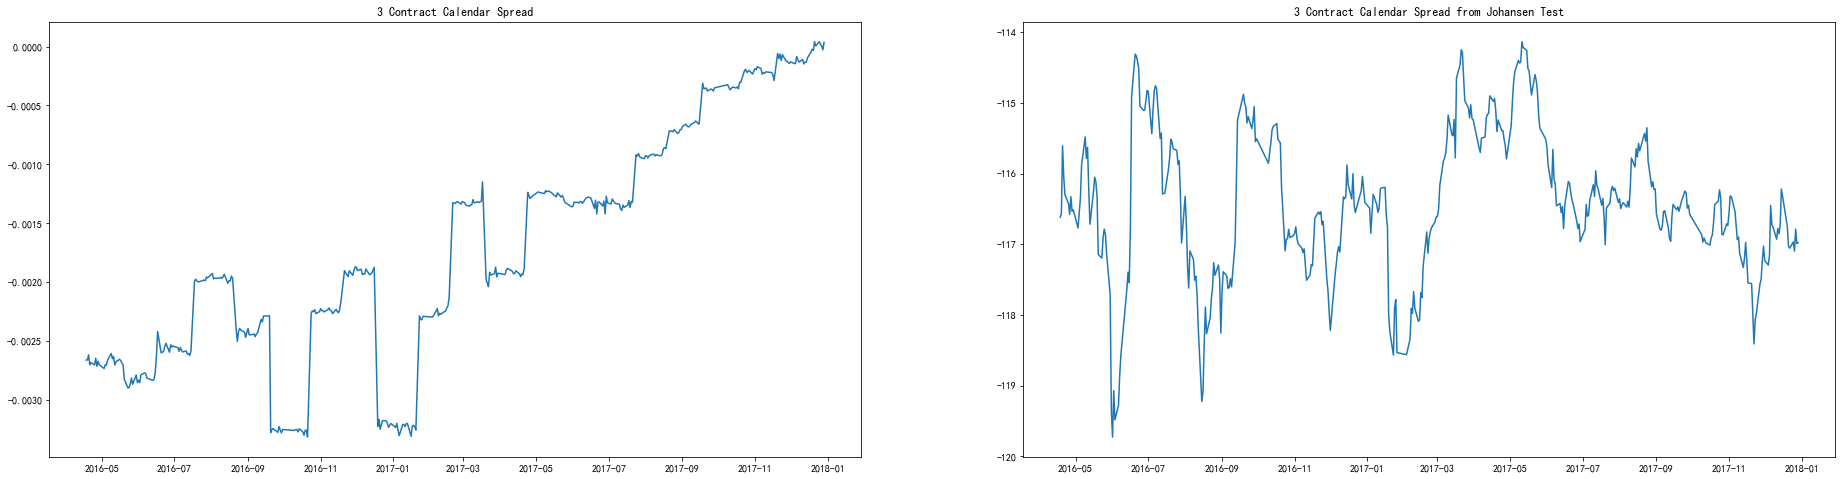

In [41]:
# 计算三个合约的期限价差
# (当月合约 - 下月合约) - (下月合约 - 下下月合约)
Calendar3Spread = (np.log(AdjCCPrice.iloc[:, 0]) - np.log(AdjCCPrice.iloc[:, 1])) / (ExpirationDays.iloc[:, 3] - ExpirationDays.iloc[:, 2])
Calendar3Spread -= (np.log(AdjCCPrice.iloc[:, 1]) - np.log(AdjCCPrice.iloc[:, 2])) / (ExpirationDays.iloc[:, 4] - ExpirationDays.iloc[:, 3])

# 平稳性检验
# ADF 检验
ADFTest = sm.tsa.stattools.adfuller(Calendar3Spread[pd.notnull(Calendar3Spread)].values, regression='c', autolag="BIC")
print("3 Contract Calendar Spread ADF Test",
      ("Statistic : %f" % ADFTest[0]), 
      ("pvalue : %f" % ADFTest[1]), 
      ("usedlag : %d" % ADFTest[2]), sep="\n", end="\n\n")

# 协整检验
X = np.log(AdjCCPrice.iloc[:, 0:3]).values
# X /= ExpirationDays.iloc[:, 2:5].values * 365
Calendar3JohansenTest = sm.tsa.var.vecm.coint_johansen(X, det_order=0, k_ar_diff=1)
for i in range(Calendar3JohansenTest.lr1.shape[0]):
    print(("---------- 3 Contract Calendar Cointegration Johansen Test: r<=%d ----------" % (i, )),
          ("Trace Statistic : %f" % (Calendar3JohansenTest.lr1[i], )), 
          ("Critical Values (90%%, 95%%, 99%%) : %s" % (str(Calendar3JohansenTest.cvt[i]), )), 
          ("Maximum Eigenvalue Statistic Statistic : %f" % (Calendar3JohansenTest.lr2[i], )), 
          ("Critical Values (90%%, 95%%, 99%%) : %s" % (str(Calendar3JohansenTest.cvm[i]), )), sep="\n", end="\n\n")
print("对冲比例："+str(Calendar3JohansenTest.evec[:, 0]))

Fig, Axes = plt.subplots(1, 2, figsize=(32, 8))
Axes[0].plot(Calendar3Spread)
Axes[0].set_title("3 Contract Calendar Spread");
Axes[1].plot(Calendar3Spread.index, np.dot(X, Calendar3JohansenTest.evec[:, 0]))
Axes[1].set_title("3 Contract Calendar Spread from Johansen Test");

# References

[<a id="cit-Chan:2013" href="#call-Chan:2013">Chan:2013</a>] Ernest Chan, ``_Algorithmic trading: winning strategies and their rationale_'',  2013.

